In [ ]:
# pip install clean-text
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gensim
from cleantext import clean
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

# Cleaning 

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
#def remove_stopwords(text, stopwords):
#    text_words = ''.join(text)
#    word_tokens = word_tokenize(text_words) 
#    text_words = [w for w in word_tokens if not w in stop_words]
#    return text_words

def preprocess(texts, language):
    import string
    translator=str.maketrans('','',string.punctuation)
    texts = [text.translate(translator) for text in texts]
    texts= [clean(x, lower=True,no_line_breaks=True,
                  no_currency_symbols= True,no_urls=True,no_emails=True, no_phone_numbers=True,
                  no_numbers=True,no_digits=True,
                  replace_with_url="",
                  replace_with_email="",
                  replace_with_phone_number="",
                  replace_with_number="",
                  replace_with_currency_symbol="",
                  replace_with_digit="", lang=language) for x in texts]
    #texts = [remove_stopwords(text, stop_words) for text in texts]
    return texts


In [ ]:
# preprocess texts  
# multiple output lines 
import os
input_dir_raw = 'data/heise/'
input_file = os.path.join(os.path.abspath(input_dir_raw), 'heise.txt')
print(input_file)
with open(input_file, 'r', encoding='utf-8') as file:
    #line for line in file:
    _input = file.readlines()


In [11]:
texts = _input
cleaned_texts = preprocess(texts,'en')

In [12]:
#texts[0]
#cleaned_texts[0]

'eBay launches visual search tools that let you shop using photos from your phone or web0eBay today is launching two new visual search tools that will allow online shoppers to use photos they snap, have saved on their phone, or even those they find while browsing the web or other social networking sites, in order to find matching products from eBay’s catalog. The tools, Image Search and Find it on eBay, leverage advancements in computer vision and deep learning, including the use of neural networks, the company notes.The first tool, Image Search, allows mobile consumers to take a photo of something they want to buy or use an image saved to their phone’s Camera Roll in order to shop eBay. The website will then return listings of items that are either a close match or at least visually similar to the product you’ve photographed.While other sites, including Amazon, Pinterest, retailers like Wayfair, and even Google, also have visual search capabilities today, eBay touted that the size of 

['ebay',
 'launches',
 'visual',
 'search',
 'tools',
 'let',
 'shop',
 'using',
 'photos',
 'phone',
 'webebay',
 'today',
 'launching',
 'two',
 'new',
 'visual',
 'search',
 'tools',
 'allow',
 'online',
 'shoppers',
 'use',
 'photos',
 'snap',
 'saved',
 'phone',
 'even',
 'find',
 'browsing',
 'web',
 'social',
 'networking',
 'sites',
 'order',
 'find',
 'matching',
 'products',
 'ebay',
 "'s",
 'catalog',
 'tools',
 'image',
 'search',
 'find',
 'ebay',
 'leverage',
 'advancements',
 'computer',
 'vision',
 'deep',
 'learning',
 'including',
 'use',
 'neural',
 'networks',
 'company',
 'notesthe',
 'first',
 'tool',
 'image',
 'search',
 'allows',
 'mobile',
 'consumers',
 'take',
 'photo',
 'something',
 'want',
 'buy',
 'use',
 'image',
 'saved',
 'phone',
 "'s",
 'camera',
 'roll',
 'order',
 'shop',
 'ebay',
 'website',
 'return',
 'listings',
 'items',
 'either',
 'close',
 'match',
 'least',
 'visually',
 'similar',
 'product',
 "'ve",
 'photographedwhile',
 'sites',
 'inc

In [13]:
from dlutils import dlutils
_input = [' '.join(x) for x in cleaned_texts]
_input, vocab = dlutils.popularity_based_prefiltering(_input, min_df = 0.05, max_df = 0.5, stopwords = stop_words)

0.05 0.5
1188 words in the vocabulary


In [14]:
x = [kk.split() for kk in _input]

In [15]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
class Documents(object):
    """
    """
    
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words=doc, tags=[i])
            
x_docs = Documents(cleaned_texts)

In [16]:
model = Doc2Vec(vector_size=100,
                dbow_words=1,
                dm=0,
                epochs=1,
                window=5,
                seed=123,
                min_count=5,
                workers=6,
                alpha=0.025,
                min_alpha=0.025)

print('Building vocab')
model.build_vocab(x_docs)

C:\Users\Viktoria\Anaconda3\envs\pvtm\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Building vocab


In [17]:
doc_counts = len(x)
for epoch in range(2):
    print("epoch " + str(epoch))
    model.train(x_docs, total_examples=doc_counts, epochs=1)
#     model.save(MODEL_SAVE_NAME)
    model.alpha -= 0.002  # decrease the learning rate
    model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 1


In [18]:
import numpy as np
# store the DocVecs to tsv
vectors = np.array(model.docvecs.vectors_docs)
# Detect the language of the documents and load the respective stopwords
vocab = list(model.wv.vocab.keys())

In [19]:
from sklearn import mixture
n_topics=20
gmm = mixture.GaussianMixture(n_components=n_topics,
                              covariance_type='tied',
                              verbose=1,
                              n_init=1)

gmm.fit(vectors[:3000,:])
print('BIC: {}'.format(gmm.bic(vectors)))

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True


GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
        means_init=None, n_components=20, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=1,
        verbose_interval=10, warm_start=False, weights_init=None)

BIC: -749336.6192882019


In [20]:
model.wv.vectors.shape

(28351, 100)

In [21]:
def get_gmm_cluster_center(vectors, gmm):
    """
    Approximates cluster centers for a given clustering from a GMM.
    Only takes the topic with the highest probability per document into account.
    Averaging the document vectors per topic cluster provides the cluster center for the topic.
    Returns a list of the cluster centers.
    """
    gmm_clustercenter = []
    
    assignments = gmm.predict(vectors)
    n_components = np.unique(assignments).shape[0]
    for i in range(n_components):
        gmm_centerindexe = np.where(assignments==i, True, False)
        
        gmm_clustercenter.append(vectors[gmm_centerindexe].mean(0))

    return gmm_clustercenter

In [47]:
def get_gmm_cluster_center_probas(vectors, gmm):
    """
    Approximates cluster centers for a given clustering from a GMM with weighted single vectors from a certain topic.
    """
    gmm_clustercenter = []
    
    assignments_proba = gmm.predict_proba(vectors)
    n_components = assignments_proba.shape[1] # spaltenanzahl der resultierenden Matrix 
    for i in range(n_components):
        center = []
        for j in range(len(vectors)):
            center_j = vectors[j]*assignments_proba[:,i][j]
            center.append(center_j)
        gmm_clustercenter.append(np.mean(center,axis=0))

    return gmm_clustercenter

In [29]:
center = get_gmm_cluster_center(vectors, gmm)
len(center)

20

In [48]:
center_probas = get_gmm_cluster_center_probas(vectors, gmm)

In [49]:
len(center_probas)

20

In [50]:
from sklearn.metrics.pairwise import cosine_similarity

sims = cosine_similarity([center_probas[0]], model.wv.vectors)

sims = np.argsort(sims)[0][::-1]

#[model.wv.index2word[k] for k in sims[:25]]

In [51]:
def create_wordcloud(topic):
    import matplotlib.pyplot as plt
    from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
    sims = cosine_similarity([center_probas[topic]], model.wv.vectors)
    sims = np.argsort(sims)[0][::-1]
    text = [model.wv.index2word[k] for k in sims[:100]]
    text = ', '.join(text)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    pp.savefig()
#    plt.show()


## View top 25 cluster words

In [35]:
import pandas as pd
top_words = pd.DataFrame()
for i in range(n_topics):
    sims = cosine_similarity([center_probas[i]], model.wv.vectors)
    sims = np.argsort(sims)[0][::-1]
    words= [model.wv.index2word[k] for k in sims[:25]]
    topic_df = pd.DataFrame(words)
    top_words = pd.concat([top_words,topic_df], axis=1)

In [36]:
mylist= list(range(1, n_topics+1))
top_words.columns = ['topic_' + str(s) for s in mylist]
top_words

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20
0,netneutrality,turnbased,neweggs,electrified,boilerplate,ast,krack,stunt,impairment,expressvpn,problemsolving,allscreen,yacob,remitly,navient,xv,skyrocket,budgeting,woodwork,onear
1,preemption,exhilarating,preblack,roadways,decorators,invocation,vaultek,mediathe,parkinson,vyprvpn,reinforcement,camerathe,cemetery,valuing,wrongdoing,bloxels,etherium,copywriter,pincodes,rha
2,repealed,dungeons,ktvs,powertrain,teletype,recursively,multifactor,crunchet,degenerative,windscribe,gans,ssamsung,kuryokhin,entwistle,assange,crate,mytime,imposter,pandoras,iconx
3,obamaera,singleplayer,walmarts,moia,filesystem,boolean,misconfigured,periscope,metabolic,nordvpn,humanly,phonethe,ezra,solium,nene,samurai,withdrawals,lifechanging,cruising,inear
4,rulesthe,gameplay,alta,shuttles,reactnavigation,gzipped,backdoor,objectionable,influenza,vpns,ais,workhowever,tragedy,lps,transworld,lynx,erc,solopreneur,usonly,urbeats
5,repealing,pacman,dealscyber,arcimoto,serialization,null,serverthe,preroll,neurological,zenmate,augmentation,frontthe,famine,seedstage,aimco,openworld,nem,motivate,pageit,waterproofing
6,enforceable,platformer,gamestop,nissans,asynchronously,constants,credential,newsfeed,lifethreatening,buffered,learnability,singlelens,brecht,graphcore,pence,actionpacked,remittance,deadlines,nowfor,ultrabooks
7,reclassify,caves,bothblack,carmaker,emailboss,definitions,ssns,blogging,homeopathic,usenet,higgs,dualcamera,apocalyptic,payu,siu,roleplaying,exmo,entails,nowif,firstgen
8,antinet,platforming,dealsblack,minivans,loaders,integers,disclosing,prioritizes,deterioration,arethis,unsupervised,xthe,pereira,venturebacked,khan,sideon,ethearnal,succeeds,reservation,earphones
9,overturn,puzzler,bigticket,automobiles,twirp,recursive,bypassed,jenner,inflammation,ipvanish,cnns,indisplay,saint,ballooning,refusal,singleplayer,crowdsale,oncall,giveaway,audiotechnica


## Save wordclouds as pdf 

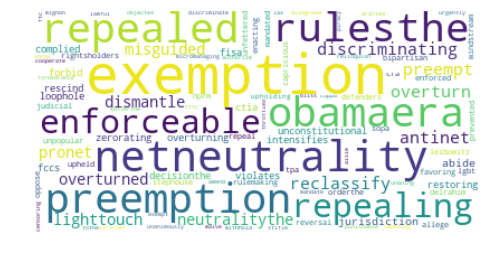

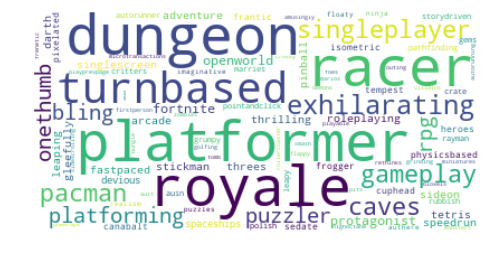

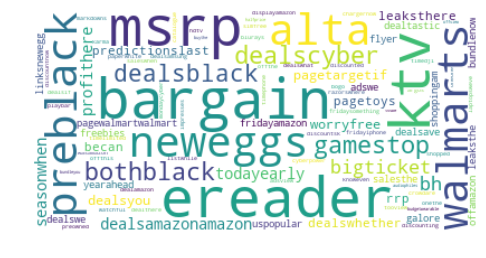

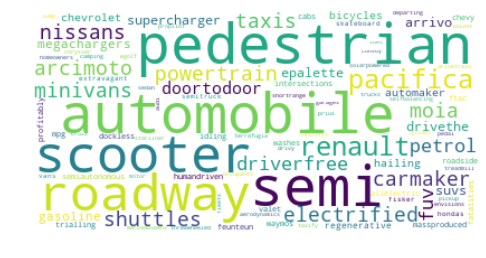

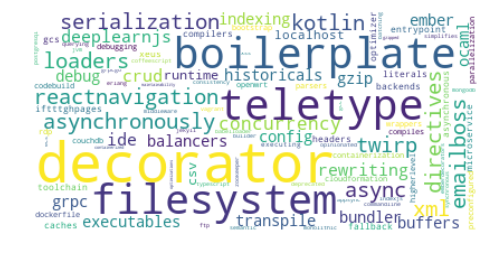

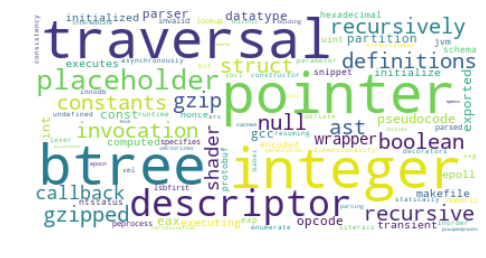

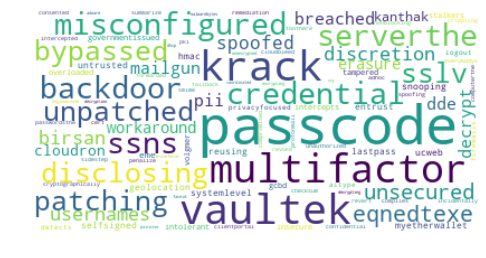

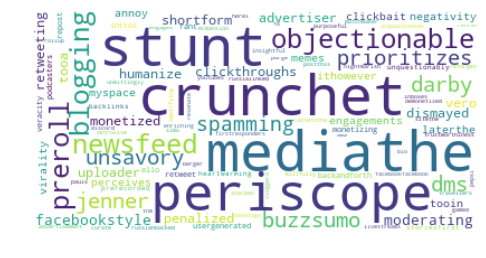

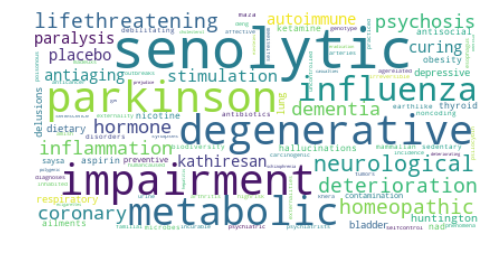

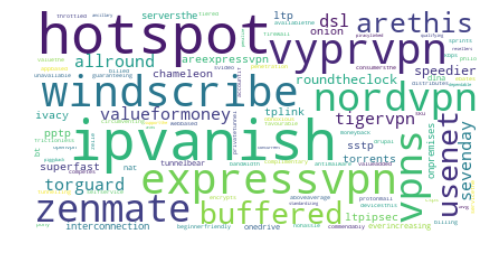

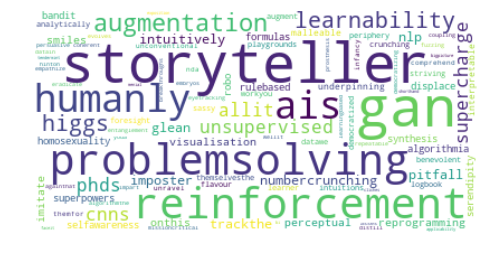

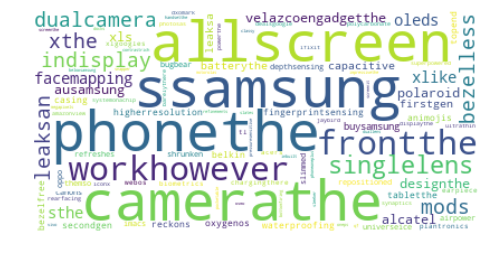

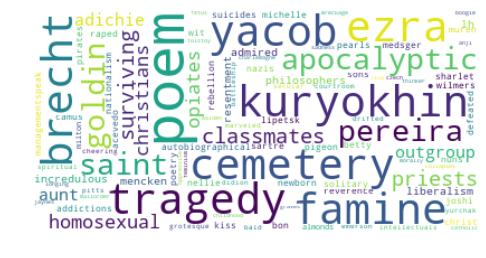

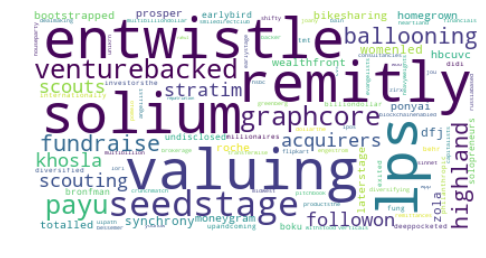

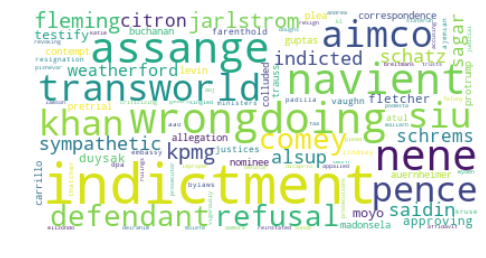

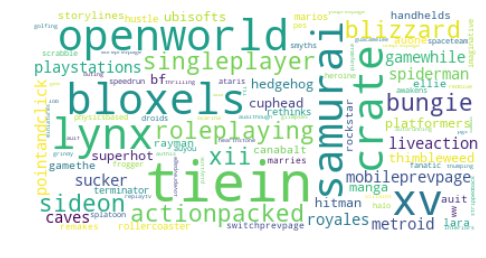

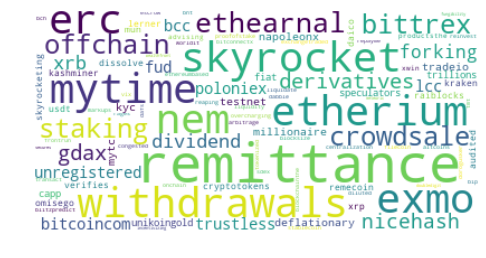

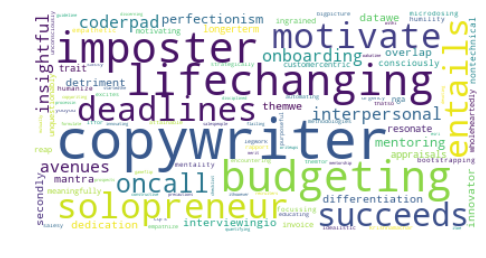

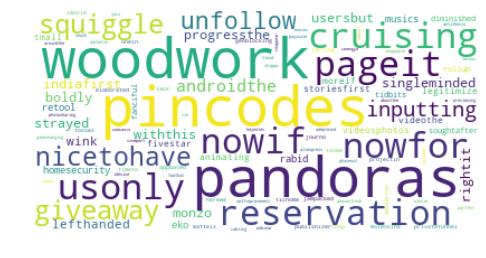

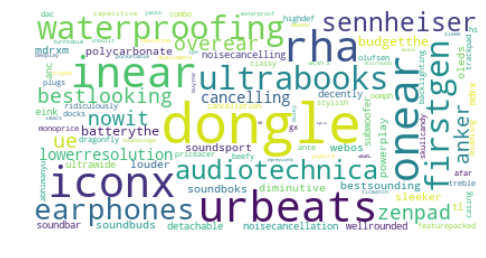

In [52]:
#import matplotlib.backends.backend_pdf
#pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages('heise_20.pdf')
for i in range(n_topics): ## will open an empty extra figure :(
    fig = create_wordcloud(i)
   # pdf.savefig(fig)
#pdf.close()
pp.close()

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne=TSNE()
%time d2vecs = tsne.fit_transform(np.vstack([vectors, center_probas]))


Wall time: 3min 33s


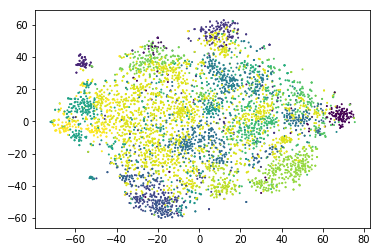

In [41]:
assignments = gmm.predict(vectors)
plt.scatter(d2vecs[:vectors.shape[0], 0], d2vecs[:vectors.shape[0], 1],c=assignments, s=1)